# 연습문제 1. Bayesian Optimization로 HyperParameter 튜닝하기


In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
cancer = load_breast_cancer()

In [ ]:
# DataFrame으로 만들기
x_data = pd.DataFrame(cancer.data, columns = cancer.feature_names)
y_data = pd.DataFrame(cancer.target)

x_data, x_test, y_data, y_test =  train_test_split(x_data, y_data, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val =  train_test_split(x_data, y_data, test_size=0.1, shuffle=True, stratify = y_data, random_state=34)

In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
 
x_train_dmat = xgb.DMatrix(data=x_train, label=y_train)
 
 
def model_evaluation(max_depth, gamma, colsample_bytree,min_child_weight,eta,subsample):
    params = {'eval_metric': 'auc',
              'objective':'binary:logistic',
              'min_child_weight': min_child_weight,
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': eta,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, x_train_dmat, num_boost_round=100, nfold=3, metrics = 'auc')
    return cv_result['test-auc-mean'].iloc[-1]
 
xgb_bo = BayesianOptimization(model_evaluation, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9),
                                            'min_child_weight': (5, 9),
                                            'eta':(0.1, 0.3),
                                            'subsample':(0.7,1.0)},random_state = 0 )
 
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------


<ipython-input-6-e97c359f299a>:27: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')


| 1         | 0.9851    | 0.6293    | 0.243     | 0.6028    | 5.18      | 6.695     | 0.8938    |
| 2         | 0.9833    | 0.5626    | 0.2784    | 0.9637    | 4.534     | 8.167     | 0.8587    |
| 3         | 0.9846    | 0.6408    | 0.2851    | 0.07104   | 3.349     | 5.081     | 0.9498    |
| 4         | 0.9841    | 0.6086    | 0.1274    | 0.6461    | 3.649     | 8.542     | 0.8785    |
| 5         | 0.9857    | 0.6268    | 0.1584    | 0.5164    | 5.199     | 6.216     | 0.9371    |
| 6         | 0.9867    | 0.6954    | 0.2663    | 0.2667    | 5.867     | 5.561     | 0.7857    |
| 7         | 0.9877    | 0.6909    | 0.103     | 0.862     | 6.977     | 5.026     | 0.9112    |
| 8         | 0.9878    | 0.3       | 0.1       | 0.0       | 7.0       | 5.0       | 1.0       |


In [ ]:
model = XGBClassifier(colsample_bytree =0.3, eta = 0.1, gamma = 0, max_depth = 7, min_child_weight = 5, subsample = 1)
model.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(colsample_bytree=0.3, eta=0.1, max_depth=7, min_child_weight=5)

Validation Accuracy: 96.15%
Precision : 0.938
Recall : 1.000


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


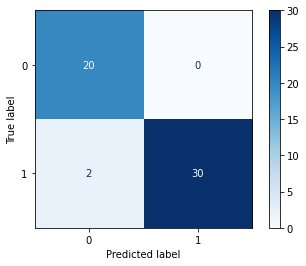

In [ ]:
plot_confusion_matrix(model, x_val, y_val, cmap = plt.cm.Blues)  

y_pred = model.predict(x_val)
predictions = [np.round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)

cm = confusion_matrix(predictions, y_val)
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]
tn = cm[0, 0]

print('Validation Accuracy: %.2f%%' % (accuracy * 100.0))
print('Precision : {:.3f}'.format(tp / (tp + fp)))
print('Recall : {:.3f}'.format(tp / (tp + fn)))

Test Accuracy: 98.25%
Precision : 0.977
Recall : 1.000


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


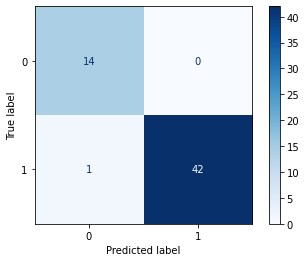

In [ ]:
plot_confusion_matrix(model, x_test, y_test, cmap = plt.cm.Blues)  

y_pred = model.predict(x_test)
predictions = [np.round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)


cm = confusion_matrix(predictions, y_test)
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]
tn = cm[0, 0]

print('Test Accuracy: %.2f%%' % (accuracy * 100.0))
print('Precision : {:.3f}'.format(tp / (tp + fp)))
print('Recall : {:.3f}'.format(tp / (tp + fn)))